# The Traveling Salesperson Problem in Julia

## Load packages

In [1]:
using Combinatorics
using Plots
using Printf
using StatsBase
using Random
using ResumableFunctions
using StatsPlots

## Exhaustive

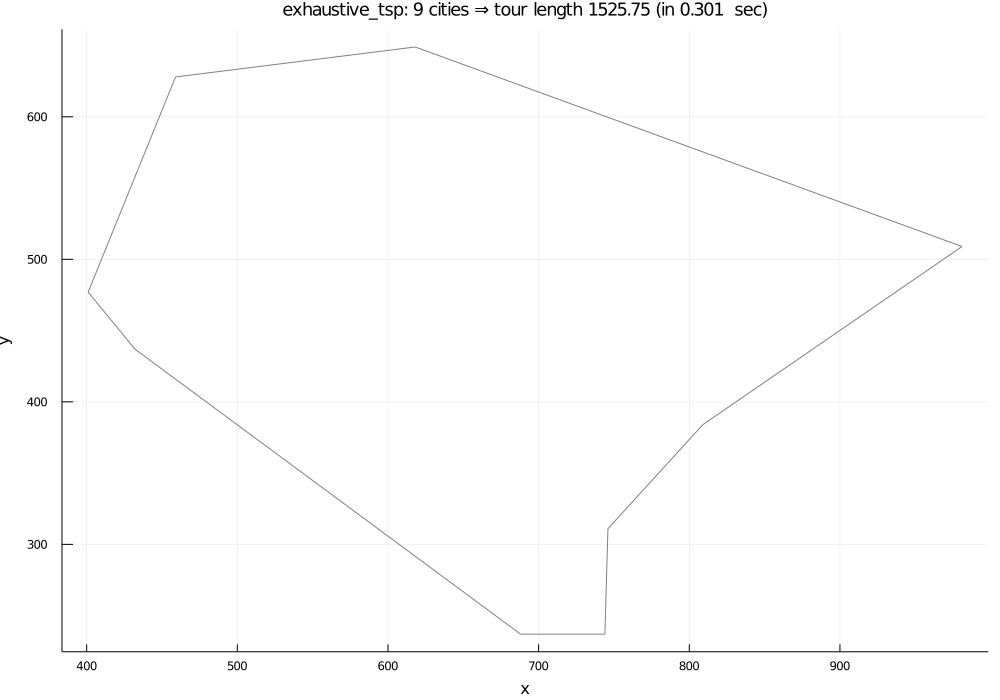

"exhaustive_tsp: 9 cities ⇒ tour length 1525.75 (in 0.301  sec)"

In [2]:
function cities(n::Int; seed::Int=123, width::Int=999, height::Int=666)
    Random.seed!(seed);
    return rand(1:width, n)+rand(1:height, n)im
end

function distance(a::Complex, b::Complex)
    return(abs(a-b))
end

function tour_length(tour)
    return sum([distance(tour[i], tour[mod1(i+1, length(tour))])
                for i in 1:length(tour)])
end

function alltours(cities)
    return collect(permutations(cities))
end

function shortest_tour(tours)
    tours[argmin([tour_length(tour) for tour in tours])]
end

function exhaustive_tsp(cities)
    return shortest_tour(alltours(cities))
end


function plot_tour(tour)
    p = plot(size = (1000,700), fmt = :png)
#    p = plot(tour[3:length(tour)], seriestype=:scatter, label = "")
#    plot!(p, tour[[1]], seriestype=:scatter, label="", color="red")
#    plot!(p, tour[[2]], seriestype=:scatter, label="", color="green")

    for i in 1:length(tour)
        plot!(p, tour[[i, mod1(i+1, length(tour))]], label = "",
                color="grey")
    end

    xlabel!(p, "x")
    ylabel!(p, "y")
    return p
end

function do_algorithm(algorithm, cities; kwargs...)
    time = @elapsed tour = algorithm(cities; kwargs...)
    plot = plot_tour(tour)

    text = @sprintf("%s: %i cities ⇒ tour length %.2f (in %.3f  sec)",
            nameof(algorithm),
            length(tour),
            tour_length(tour),
            time)

    title!(plot, text, titlefontsize=12)

    display(plot)
    return text
end

do_algorithm(exhaustive_tsp, cities(9))

## NN 

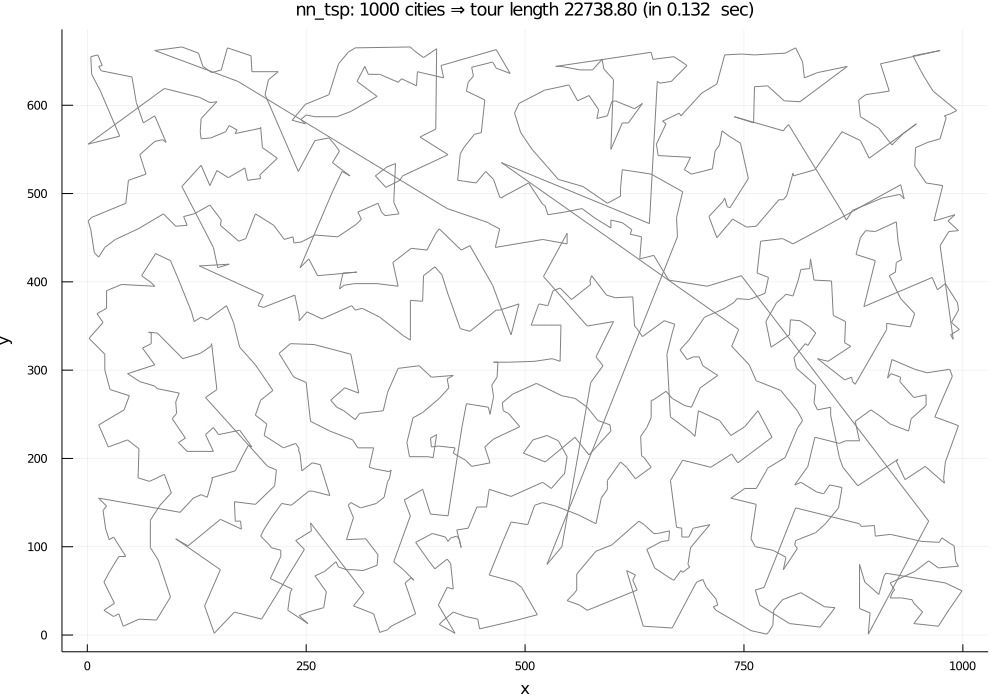

"nn_tsp: 1000 cities ⇒ tour length 22738.80 (in 0.132  sec)"

In [3]:
function nn_tsp(cities; start::Union{Complex, Nothing}=nothing)
    C = isnothing(start) ? cities[1] : start
    tour = [C]
    unvisited = setdiff(cities, tour)
    while length(unvisited) > 0
        C = nearest_neighbor(C, unvisited)
        append!(tour, C)
        setdiff!(unvisited, C)
    end
    return tour
end

function nearest_neighbor(A, cities)
    return cities[argmin([distance(A, cities[i]) for i in 1:length(cities)])]
end


do_algorithm(nn_tsp, cities(1000))

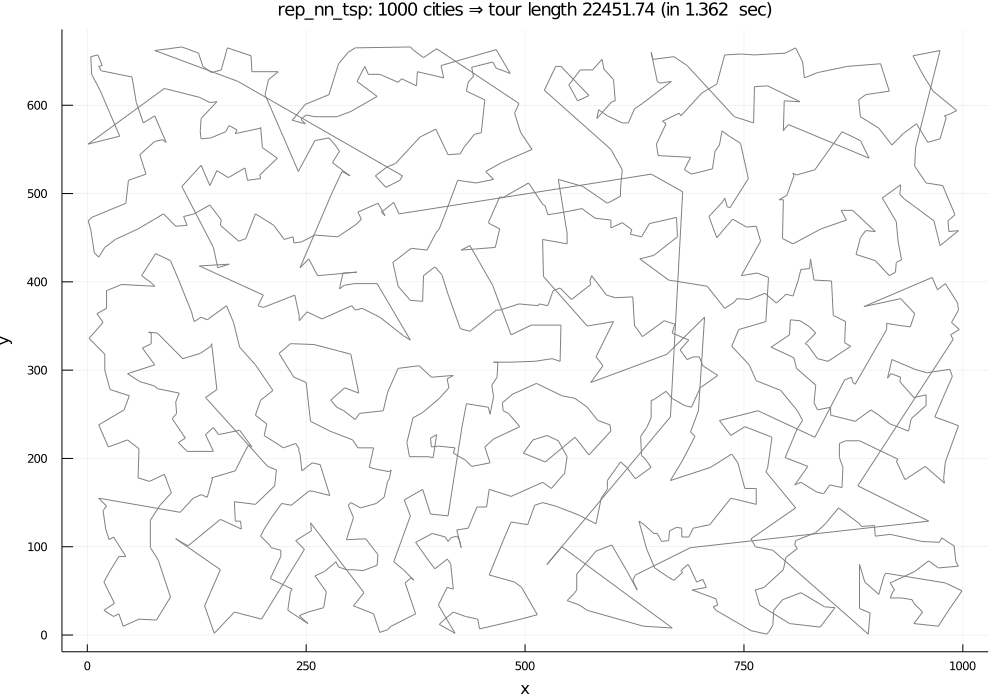

"rep_nn_tsp: 1000 cities ⇒ tour length 22451.74 (in 1.362  sec)"

In [4]:
function rep_nn_tsp(cities; k::Int=25, seed::Int=42)
    Random.seed!(seed)
    k = k > length(cities) ? length(cities) : k
    return shortest_tour([nn_tsp(cities, start=start) for start in sample(cities, k, replace=false)])
end

do_algorithm(rep_nn_tsp, cities(1000))

### Real world example: US cities

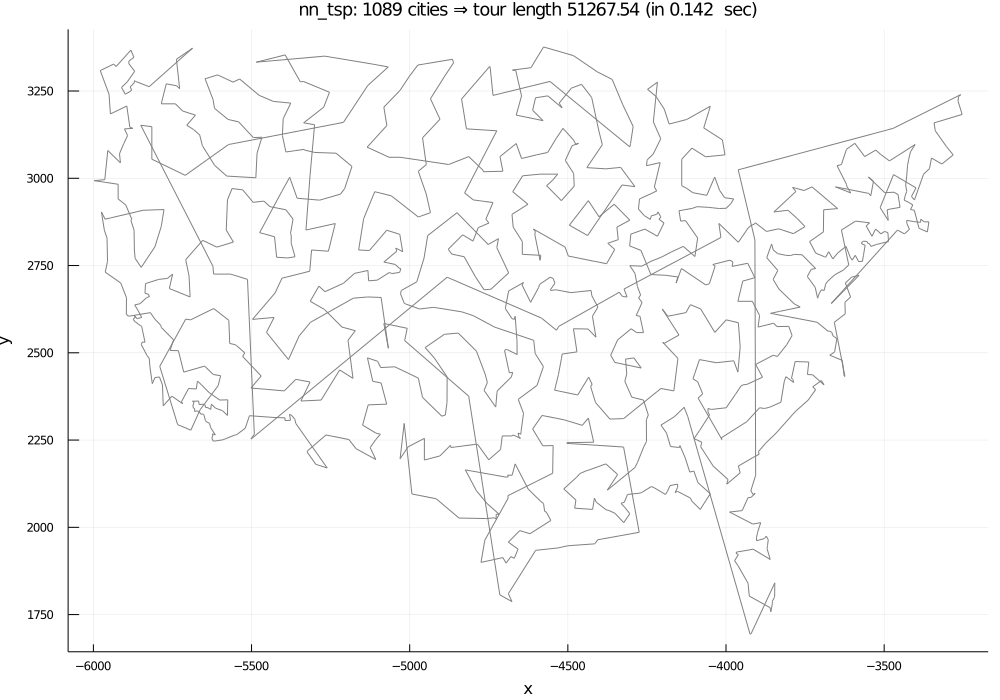

"nn_tsp: 1089 cities ⇒ tour length 51267.54 (in 0.142  sec)"

In [5]:
function parse_cities(file, long_scale=-48, lat_scale=69)
    cities = Complex{Float64}[]
    open(file) do io
        while !eof(io)
            line = readline(io)
            if startswith(line, "[") && !occursin(",AK", line) && !occursin(",HI", line)
                long = parse(Float64, split(line, "  ")[3])*long_scale
                lat = parse(Float64, split(line, "  ")[2])*lat_scale

                append!(cities, complex(long,lat))
            end
        end
    end
    return cities
end

const us_cities = unique(parse_cities("latlong.htm"))


do_algorithm(nn_tsp, us_cities)

### Improve tour - Eliminate crossings

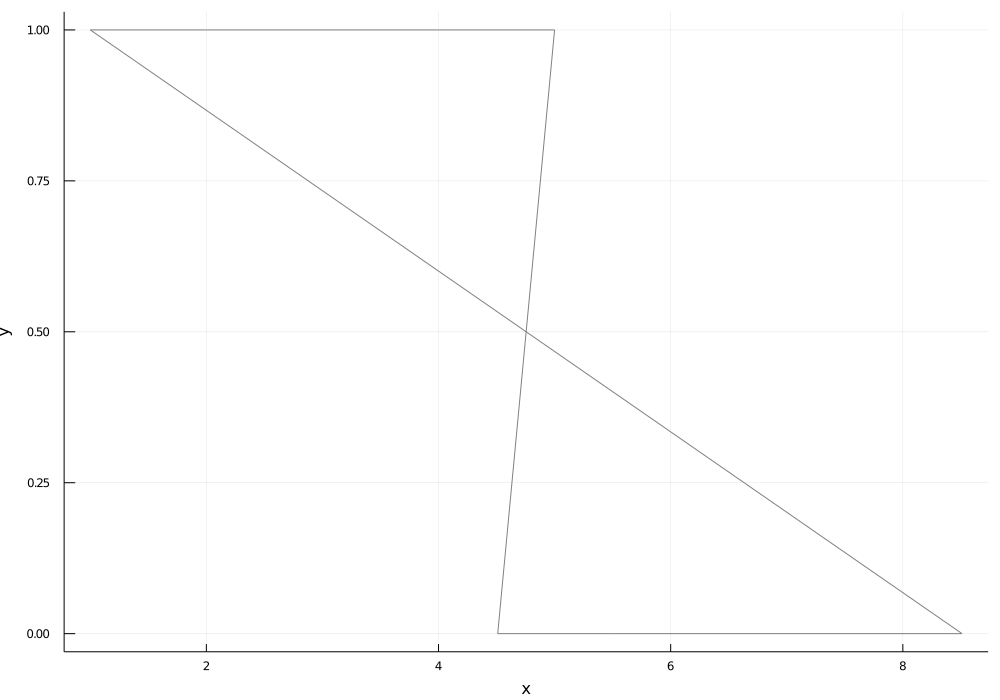

In [6]:
cities10 = vcat([complex(x, 1) for x in 1:5],[
    complex(x-1.49, 0) for x in 6:10])


function reverse_segment_if_improvement!(tour, i::Int, j::Int)
    A, B, C, D = tour[mod1(i-1, length(tour))], tour[i], tour[j], tour[mod1(j+1, length(tour))]

    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D)
        # this is a mutation, not a assignement
        # thus it changes tour
        # https://stackoverflow.com/questions/33002572/creating-copies-in-julia-with-operator
        tour[i:j] = reverse(tour[i:j])
        return true
    else
        return false
    end
end

path = nn_tsp(cities10)
plot_tour(path)



In [7]:
tour_length(path)


16.689883142479694

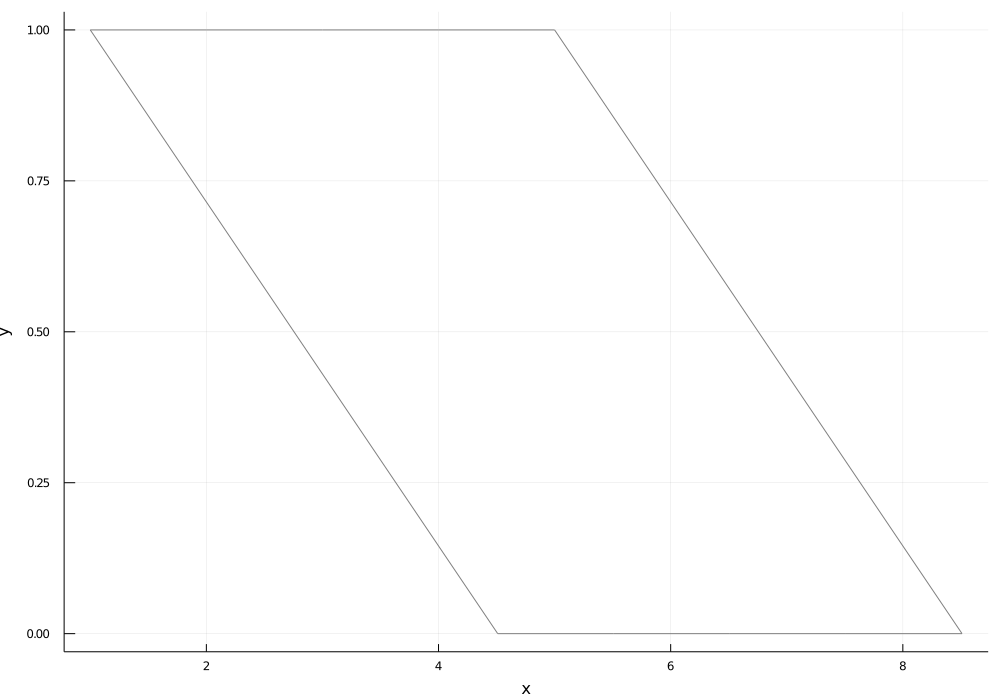

In [8]:
reverse_segment_if_improvement!(path, 6,10)
plot_tour(path)


In [9]:
tour_length(path)

15.299342436137657

In [10]:
## Improve NN

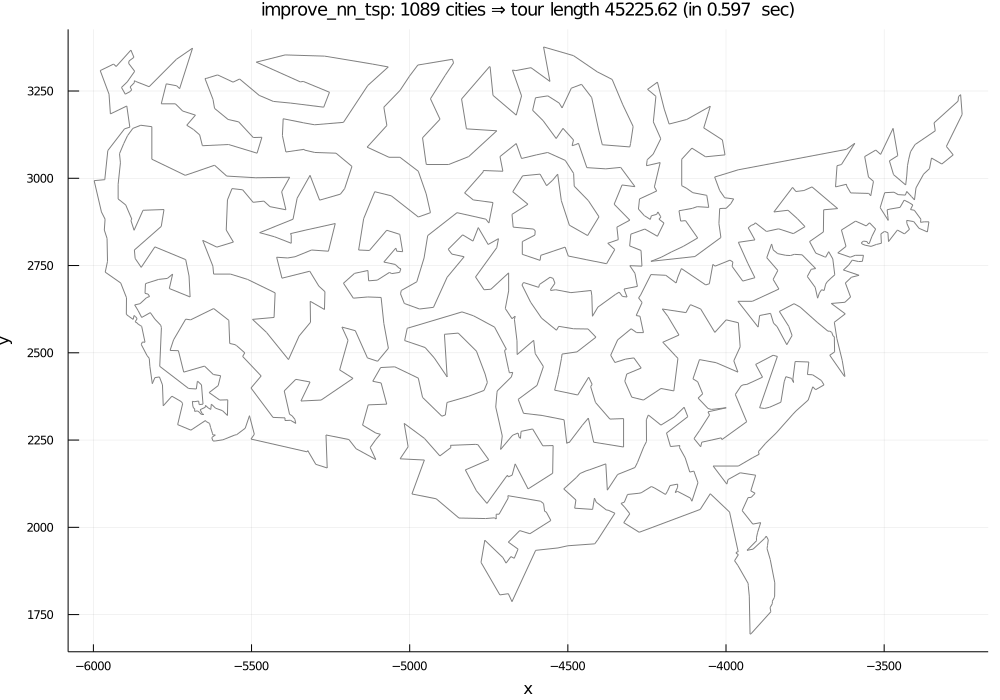

"improve_nn_tsp: 1089 cities ⇒ tour length 45225.62 (in 0.597  sec)"

In [11]:
function improve_tour(tour)
    while true
        improvements = [reverse_segment_if_improvement!(tour, i, j)
                        for (i, j) in zip(subsegments(length(tour))...)]
        if !any(improvements .== true)
            return tour
        end
    end
end

function subsegments(N::Int)
    "Return (i, j) pairs denoting tour[i:j] subsegments of a tour of length N."
    s = zeros(Int,0)
    e = zeros(Int,0)
    for length in reverse(1:N-2), i in  reverse(1:N-length)
        append!(s, i)
        append!(e, i+length)
    end
    return [s, e]
end


function improve_nn_tsp(cities)
    "Improve the tour produced by nn_tsp."
    return improve_tour(nn_tsp(cities))
end

function rep_improve_nn_tsp(cities; k::Int=5, seed::Int=42)
    Random.seed!(seed)
    k = k > length(cities) ? length(cities) : k
    starts = sample(cities, k)
    tours = Vector{Any}(nothing, length(starts))
    Threads.@threads for i in 1:length(starts)
        tours[i] = improve_tour(nn_tsp(cities, start=starts[i]))
    end
    return shortest_tour(tours)
end

do_algorithm(improve_nn_tsp, us_cities)

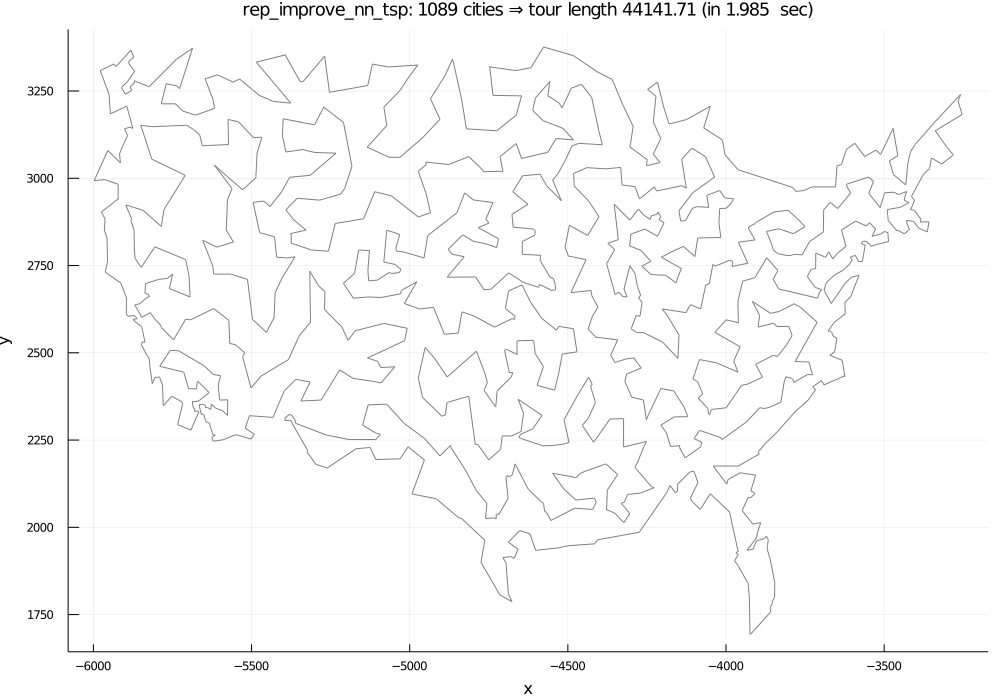

"rep_improve_nn_tsp: 1089 cities ⇒ tour length 44141.71 (in 1.985  sec)"

In [12]:
do_algorithm(rep_improve_nn_tsp, us_cities)

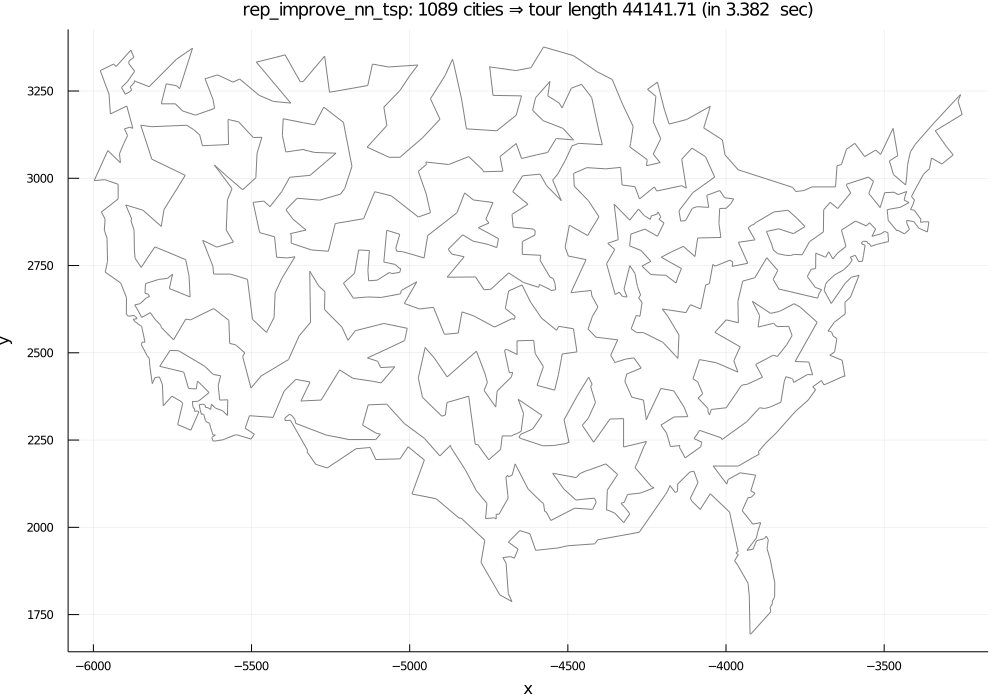

"rep_improve_nn_tsp: 1089 cities ⇒ tour length 44141.71 (in 3.382  sec)"

In [13]:
do_algorithm(rep_improve_nn_tsp, us_cities, seed=42,  k=10)

## Greedy

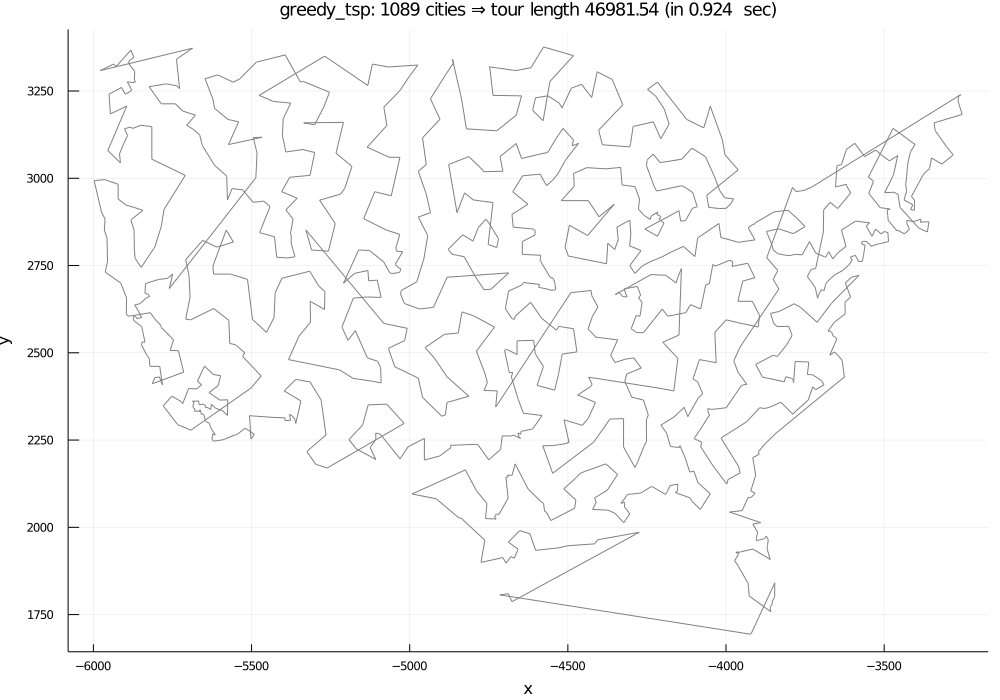

"greedy_tsp: 1089 cities ⇒ tour length 46981.54 (in 0.924  sec)"

In [14]:
function shortest_links_first(cities)
    comb = collect(combinations(cities, 2))
    return sort(comb, by=x->distance(x[1], x[2]))
end

function greedy_tsp(cities)
    """Go through links, shortest first. Use a link to join segments if possible."""
    endpoints = Dict(i => [i] for i in cities) #
    for (A, B) in shortest_links_first(cities)
        if A in keys(endpoints) && B in keys(endpoints) && endpoints[A] != endpoints[B]
            new_segment = join_endpoints(endpoints, A, B)
            if length(new_segment) == length(cities)
                return new_segment
            end
        end
    end
end

function join_endpoints(endpoints, A, B)
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    if Aseg[length(Aseg)] != A
        reverse!(Aseg)
    end
    if Bseg[1] != B
        reverse!(Bseg)
    end
    Aseg = vcat(Aseg,Bseg)
    delete!(endpoints, A)
    delete!(endpoints, B)
    endpoints[Aseg[1]] = endpoints[Aseg[length(Aseg)]] = Aseg
    return Aseg
end

function improve_greedy_tsp(cities)
    return improve_tour(greedy_tsp(cities))
end

do_algorithm(greedy_tsp, us_cities)

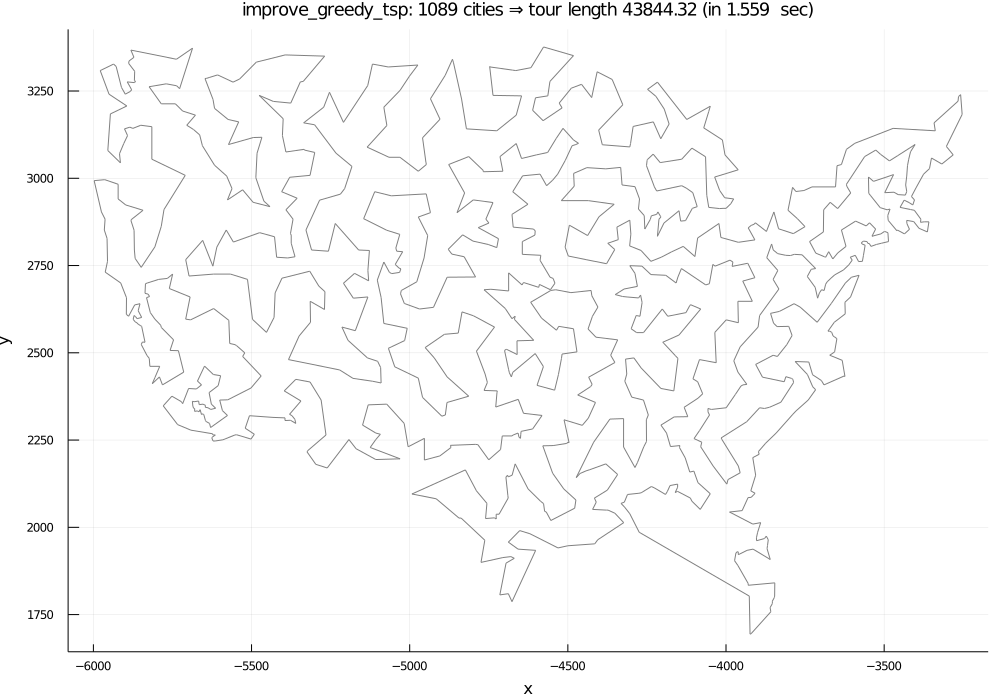

"improve_greedy_tsp: 1089 cities ⇒ tour length 43844.32 (in 1.559  sec)"

In [15]:
do_algorithm(improve_greedy_tsp, us_cities)

## Divide

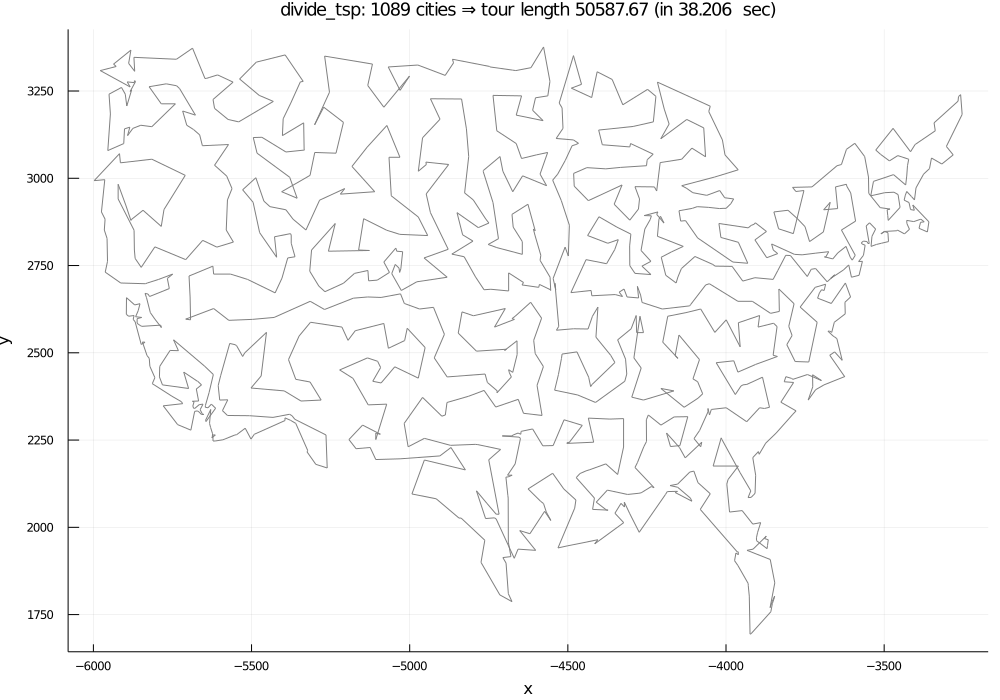

"divide_tsp: 1089 cities ⇒ tour length 50587.67 (in 38.206  sec)"

In [16]:
function divide_tsp(cities; n=6)
    """Find a tour by divide and conquer: if number of cities is n or less, use exhaustive search.
    Otherwise, split the cities in half, solve each half recursively,
    then join those two tours together."""
    if length(cities) <= n
        return exhaustive_tsp(cities)
    else
        half1, half2 = split_cities(cities)
        return join_tours(divide_tsp(half1, n=n), divide_tsp(half2, n=n))
    end
end

function split_cities(cities)
    "Split cities vertically if map is wider; horizontally if map is taller."
    width  = maximum(real(cities)) - minimum(real(cities))
    height = maximum(imag(cities)) - minimum(imag(cities))
    cities = sort(cities, by=x-> width>height ? real(x) : imag(x))
    middle = fld(length(cities), 2)
    return cities[1:middle], cities[middle+1:end]
end

function join_tours(tour1, tour2)
    "Consider all ways of joining the two tours together, and pick the shortest."
    segments1, segments2 = rotations(tour1), rotations(tour2)
    tours = Any[]
    for s1 in segments1, s in segments2, s2 in [s, reverse(s)]
        append!(tours, [vcat(s1, s2)])
    end
    return shortest_tour(tours)
end

function rotations(sequence)
    "All possible rotations of a sequence."
    # A rotation is some suffix of the sequence followed by the rest of the sequence.
    return [vcat(sequence[i+1:end], sequence[1:i]) for i in 1:length(sequence)]
end

function improve_divide_tsp(cities; n=6)
    return improve_tour(divide_tsp(cities, n=n))
end

do_algorithm(divide_tsp, us_cities)

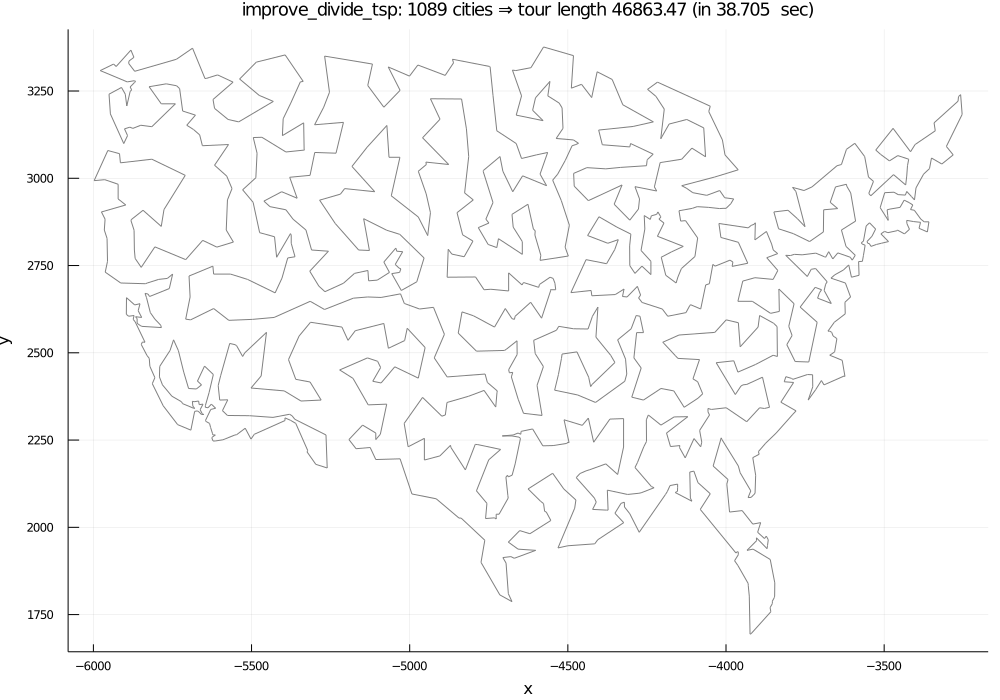

"improve_divide_tsp: 1089 cities ⇒ tour length 46863.47 (in 38.705  sec)"

In [17]:
do_algorithm(improve_divide_tsp, us_cities)

## MST

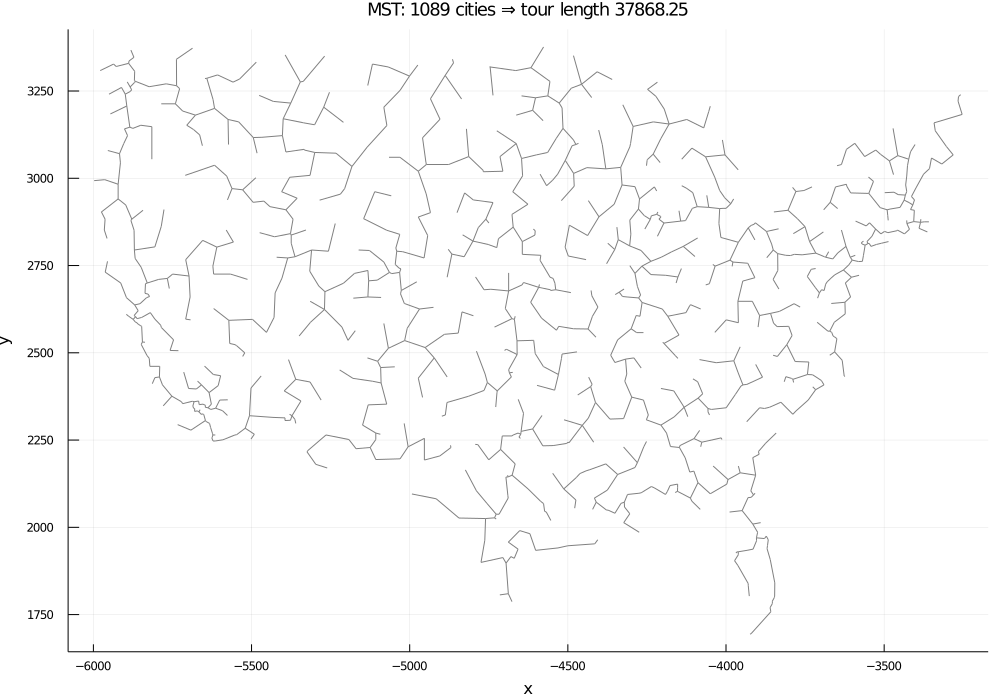

In [18]:
"""
Given a set of vertexes, build a minimum spanning tree: a dict of the form
{parent: [child...]}, spanning all vertexes.
"""
function mst(vertexes)
    tree  = Dict(vertexes[1] => ComplexF64[]) # the first city is the root of the tree.
    links = shortest_links_first(vertexes)
    while length(tree) < length(vertexes)
        for (A, B) in links
            if (A in keys(tree)) ⊻ (B in keys(tree)) #XOR
                if B in keys(tree) # reverse if B in tree
                    (A, B) = (B, A)
                end
                append!(tree[A], B)
                tree[B] = ComplexF64[]
                break # end current for loop
            end
        end

    end
    return tree
end

function plot_mst(tree)
    l = 0
    p = plot(size=(1000,700), fmt = :png)
    for (parent, childs) in tree
        #plot!(p, [parent], seriestype=:scatter, label = "", color="blue")
        for c in childs
            plot!(p, [parent, c], label = "",   color="grey")
            l += distance(parent, c)
        end
    end

    xlabel!(p, "x")
    ylabel!(p, "y")

    text = @sprintf("%s: %i cities ⇒ tour length %.2f",
            "MST",
            length(tree),
            l)

    title!(p, text, titlefontsize=12)

    return p
end



plot_mst(mst(us_cities))

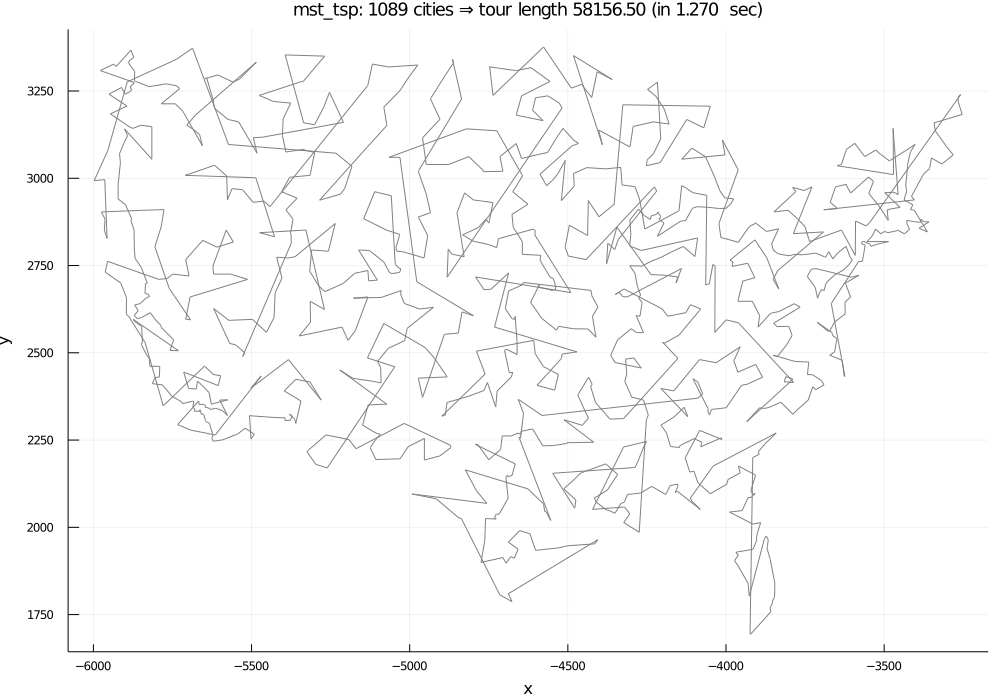

"mst_tsp: 1089 cities ⇒ tour length 58156.50 (in 1.270  sec)"

In [19]:
function mst_tsp(cities)
    "Create a minimum spanning tree and walk it in pre-order, omitting duplicates."
    return vcat(collect(preorder_traversal(mst(cities), cities[1]))...)
end

## could be improved!!
@resumable function preorder_traversal(tree, root)
    "Traverse tree in pre-order, starting at root of tree."
    @yield [root]
    for child in tree[root]
        @yield vcat(collect(preorder_traversal(tree, child))...)
    end
end

function improve_mst_tsp(cities)
    return improve_tour(mst_tsp(cities))
end

do_algorithm(mst_tsp, us_cities)

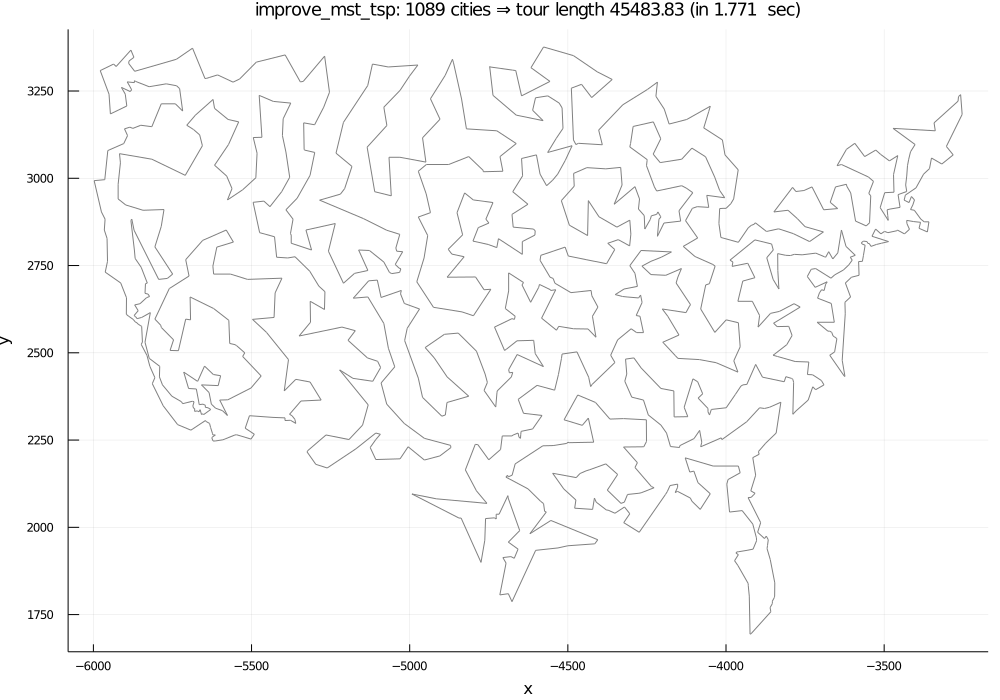

"improve_mst_tsp: 1089 cities ⇒ tour length 45483.83 (in 1.771  sec)"

In [20]:
do_algorithm(improve_mst_tsp, us_cities)

## Testing the different methods

In [21]:
function TestSuite(n, k; cities=us_cities, seed=42::Int)
    "Return n different samples from cities, each consisting of k cities."
    Random.seed!(seed)
    return [sample(cities, k, replace=false) for i in 1:n]
end


function benchmark(algorithm, tests; kwargs...)
    "Benchmark one TSP algorithm on a test suite; return ([tour_lengths], average_time)"
    times = Float64[]
    lengths= Float64[]
    for test in tests
            time = @elapsed tour = algorithm(test; kwargs...)
            append!(times, time)
            append!(lengths, tour_length(tour))
    end
    return times, lengths
end


function boxplots(algorithms, tests)
    df = Vector{Float64}[]
    labels = []
    for algorithm in algorithms
        times, lengths = benchmark(algorithm, tests)
        #insertcols!(df, nameof(algorithm) => lengths)
        append!(df, [lengths])
        append!(labels,
                [@sprintf("%s \n avg length: %.2f \n avg time: %.2f ms",
                        nameof(algorithm),
                        mean(lengths),
                        mean(times)*1000)]
                )
    end
    labels = hcat(labels...)
    df = hcat(df...)
    p = boxplot(labels, df, leg=false, size=(1000,700), fmt = :png)
    display(p)
end

boxplots (generic function with 1 method)

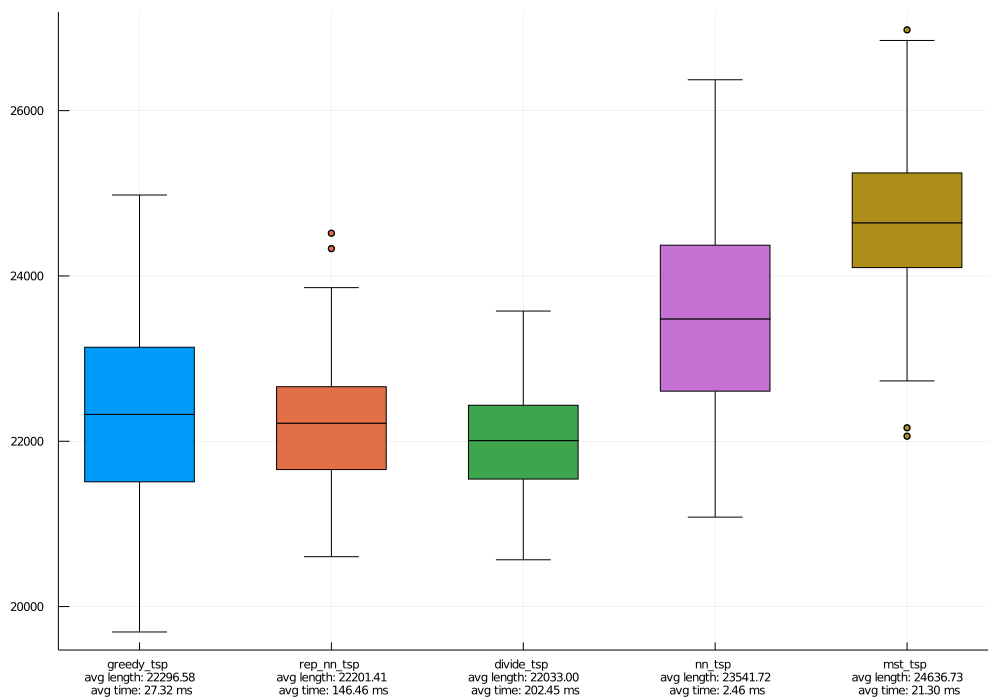

In [22]:
basic = [greedy_tsp, rep_nn_tsp, divide_tsp, nn_tsp, mst_tsp]
boxplots(basic, TestSuite(100, 200))

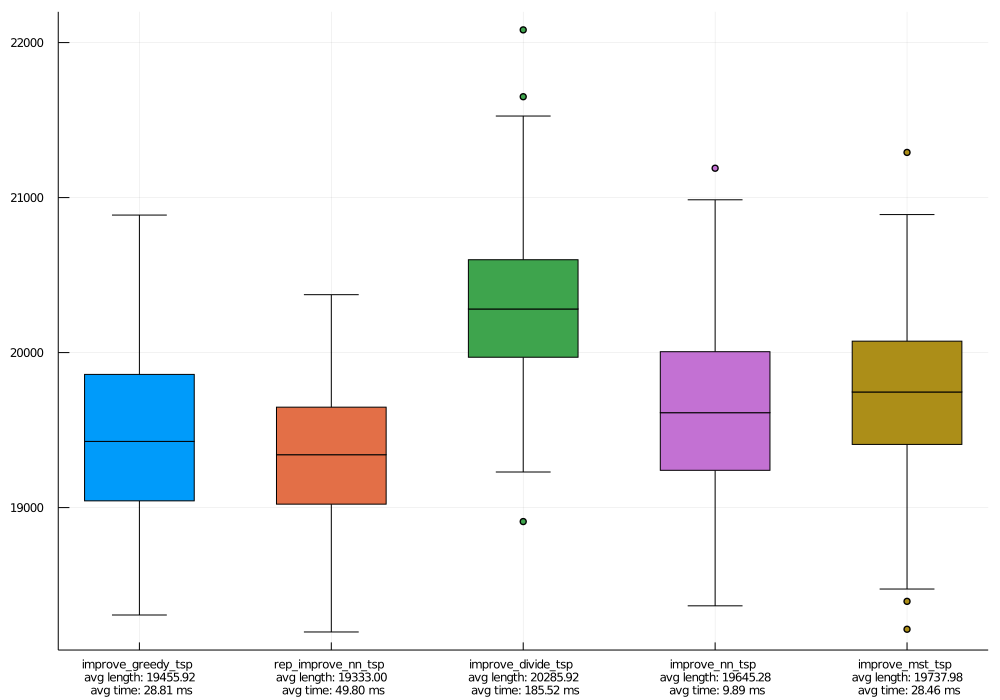

In [23]:
improved = [improve_greedy_tsp, rep_improve_nn_tsp,
            improve_divide_tsp, improve_nn_tsp,
            improve_mst_tsp]
boxplots(improved, TestSuite(100, 200))